<center>
    <H1> Choosing a place for a veg eatery in New York, Los Angeles or Chicago</H1>
    <H3> The Analysis </H3>
</center>

In [1]:
import pandas as pd
import numpy as np
import requests
import re
import warnings
warnings.filterwarnings('ignore')
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 100)
#-----------        ML         ---------------
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV
# Regression
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
# Metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from scipy.stats import zscore
from sklearn.preprocessing import minmax_scale as mms
import folium

In [215]:
df_raw = pd.read_csv('df_final.csv', 'r', delimiter=',')

The column `zip` was needed only for fetching other data, now it can be removed. Some place categores are not needed as well, let's leave only those that provide an interest to us:
`t_restaurant`, `t_meal_delivery`, `t_meal_takeaway`, `t_cafe` , `t_bar`.

In [216]:
df = df_raw.drop(['zip', 't_grocery_or_supermarket', 't_store',
                  't_bakery', 't_supermarket', 't_night_club', 't_gym',
                  't_health', 't_lodging', 't_liquor_store', 't_pharmacy'], axis=1)

In [341]:
df.head()

,name,lat,lng,rating,user_ratings_total,venues_total,venues_comp,parking,city,city_district,population,rent_median,t_restaurant,t_meal_delivery,t_meal_takeaway,t_cafe,t_bar
0,Pongal,40.742453,-73.982883,4.0,432,50.0,9.0,50.0,NYC,Manhattan,26769.0,2367.4,1.0,0.0,0.0,0.0,0.0
1,Juice Press,40.728551,-74.007428,2.7,17,24.0,6.0,50.0,NYC,Manhattan,26769.0,2367.4,1.0,0.0,0.0,0.0,0.0
2,Vatan,40.742361,-73.980337,4.3,624,50.0,7.0,50.0,NYC,Manhattan,26769.0,2367.4,1.0,0.0,0.0,0.0,0.0
3,Kajitsu,40.749853,-73.977721,4.5,162,21.0,12.0,50.0,NYC,Manhattan,26769.0,2367.4,1.0,0.0,0.0,0.0,0.0
4,Kailash Parbat,40.742063,-73.982706,4.2,625,50.0,13.0,50.0,NYC,Manhattan,26769.0,2367.4,1.0,1.0,1.0,0.0,0.0


In [5]:
df[['city', 'city_district', 'population', 'rent_median']].groupby(['city_district']).agg({'population':'median', 'rent_median':'median'}).reset_index().corr()

,population,rent_median
population,1.000000,-0.377461
rent_median,-0.377461,1.000000


In [40]:
pd.cut(df.parking, 5, labels=[1,2,3,4,5]).sample(5)

904    5
348    5
152    5
44     5
755    5
Name: parking, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [449]:
df.iloc[:,12:].sum(axis=0).sort_values(ascending=False)

t_restaurant       804.0
t_cafe             204.0
t_meal_takeaway    148.0
t_bar              76.0 
t_meal_delivery    44.0 
dtype: float64

In [12]:
df.head()

,name,lat,lng,rating,user_ratings_total,venues_total,venues_comp,parking,city,city_district,population,rent_median,t_restaurant,t_meal_delivery,t_meal_takeaway,t_cafe,t_bar
0,Pongal,40.742453,-73.982883,4.0,432,50.0,9.0,50.0,NYC,Manhattan,26769.0,2367.4,1.0,0.0,0.0,0.0,0.0
1,Juice Press,40.728551,-74.007428,2.7,17,24.0,6.0,50.0,NYC,Manhattan,26769.0,2367.4,1.0,0.0,0.0,0.0,0.0
2,Vatan,40.742361,-73.980337,4.3,624,50.0,7.0,50.0,NYC,Manhattan,26769.0,2367.4,1.0,0.0,0.0,0.0,0.0
3,Kajitsu,40.749853,-73.977721,4.5,162,21.0,12.0,50.0,NYC,Manhattan,26769.0,2367.4,1.0,0.0,0.0,0.0,0.0
4,Kailash Parbat,40.742063,-73.982706,4.2,625,50.0,13.0,50.0,NYC,Manhattan,26769.0,2367.4,1.0,1.0,1.0,0.0,0.0


In [13]:
df.city.unique()

array(['NYC', 'LA', 'Chicago'], dtype=object)

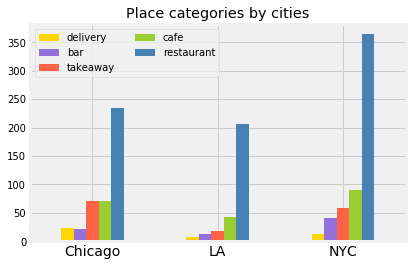

In [368]:
_ = df.iloc[:,[8,13,16,14,15,12]].groupby('city').sum()
_.columns = ['delivery', 'bar', 'takeaway', 'cafe', 'restaurant']
# _.index = ['restaurant', 'delivery', 'takeaway', 'cafe', 'bar']
clr_rev = ['gold', 'mediumpurple', 'tomato', 'yellowgreen', 'steelblue', 'pink', 'grey']
_.plot.bar(color=clr_rev)
plt.title('Place categories by cities')
plt.legend(loc='best', ncol=2)
plt.xlabel('')
plt.xticks(rotation=0, size=14)
plt.show()

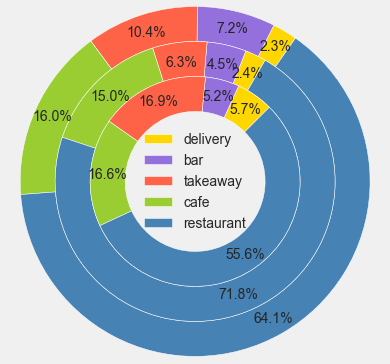

In [1043]:
# the shares of eatery types by cities can be better observed on the following combined donut chart

data = df.iloc[:,[8,13,16,14,15,12]].groupby('city').sum()
labls=['delivery', 'bar', 'takeaway', 'cafe', 'restaurant']
# names = 
g1= df.iloc[:,[8,13,16,14,15,12]].groupby('city').sum().loc['NYC'].values
g2=df.iloc[:,[8,13,16,14,15,12]].groupby('city').sum().loc['LA'].values
g3=df.iloc[:,[8,13,16,14,15,12]].groupby('city').sum().loc['Chicago'].values
# Create colors
clr = ['gold', 'mediumpurple', 'tomato', 'yellowgreen', 'steelblue', 'pink', 'gray']

# First Ring (outside)
fig, ax = plt.subplots(figsize=(6,5))

ax.axis('equal')

mypie, _, _ = ax.pie(g1, radius=1.5, autopct='%1.1f%%', pctdistance=0.9, startangle=55, colors=clr )
plt.setp( mypie, width=0.3, edgecolor='white')

# Second Ring (Middle)
mypie2, _, _ = ax.pie(g2, radius=1.2,  autopct='%1.1f%%', pctdistance=0.86, startangle=60, colors=clr )
plt.setp( mypie2, width=0.3, edgecolor='white')
plt.margins(0,0)

# Third Ring (Inside)
mypie3, _, _ = ax.pie(g3, radius=0.9, autopct='%1.1f%%', pctdistance=0.84, labeldistance=0.7, startangle=45, colors=clr )
plt.setp( mypie3, width=0.3, edgecolor='white')
plt.margins(0,0)
plt.legend(labels=labls, loc="center", fontsize='medium')
# show it
plt.show()

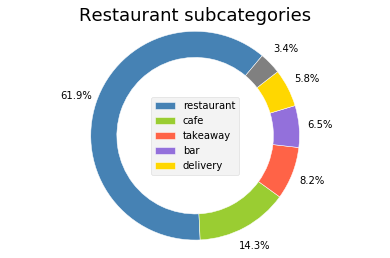

In [366]:
# as it can be seen from the figure above, the dominant eatery type among all the cities is restaurant.
# let's figure out, what subcategories they might include:
clr = ['steelblue', 'yellowgreen', 'tomato', 'mediumpurple', 'gold', 'gray', 'pink']
vals = df.query('t_restaurant == 1').iloc[:,12:].sum(axis=0).sort_values(ascending=False).values
labls = ['restaurant', 'cafe', 'takeaway', 'bar', 'delivery']
fig, ax = plt.subplots()
ax.axis('equal')
p, _, _ = ax.pie(vals, autopct='%1.1f%%',  pctdistance=1.2, radius=1.2, startangle=50, rotatelabels=True, colors=clr )
plt.setp(p, width=0.3, edgecolor='w')
plt.legend(labels=labls, loc="center", fontsize='medium')
plt.title('Restaurant subcategories', size=18)
plt.show() 


    Among all the restaurants , 27.8% of places have a hybrid nature -- they are at the same time a caffe, a takeaway, a bar or a meal delivery.  

From the columns `venues_total` and `venues_comp` let's create `comp_venues_share`, which show the share of competitive venues nearby. The latter will be further transformed into `concurrency` column with values `1-5`, ranging the level of concurrency from **very low** to **very high**.

In [22]:
df['comp_venues_total'] = round(df.venues_comp/df.venues_total,2)

In [172]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [23]:
df.sample(3)

,name,lat,lng,rating,user_ratings_total,venues_total,venues_comp,parking,city,city_district,population,rent_median,t_restaurant,t_meal_delivery,t_meal_takeaway,t_cafe,t_bar,comp_venues_total
430,Quesadilla La Reina Del Sur,41.922728,-87.687338,4.6,496,24.0,8.0,38.0,Chicago,Downtown,46703.0,986.055556,1.0,0.0,0.0,0.0,0.0,0.33
73,Village Natural,40.735699,-74.000410,4.2,130,50.0,8.0,50.0,NYC,Manhattan,33636.0,2141.666667,1.0,0.0,0.0,0.0,0.0,0.16
416,Kal'ish,41.965174,-87.663002,4.7,305,14.0,5.0,34.0,Chicago,North Side,34531.0,784.222222,1.0,0.0,0.0,0.0,0.0,0.36


For example, the resulting value `0.2` means that 20% of all venues nearby are competitive ones (other restaurants, cafe, takeaways etc)

# <font color=red> ПОКА ПОГОДИМ!</font>

In order to make further generalizations, I'll convert numeric values to "Likert-type" scale with values from 1 to 5 (from lowest to highest) based on the minimum and maximum values of converting vectors (columns):  

|  columns    | 1|2|3|4|5|
|-----------:|:---:|:---:|:---:|:---:|:---:|
|user **rating**   | very negative | negative | neutral | positive | very positive         |
|**popularity** index  <br> <small>(based on the total number of ratings)</small>|very low| low|average| high| very high|
|**competition**|very low| low|average| high| very high|
|**parking**  areas | little | less than average | average | above average | many   |
|level of **population**|very low| low|average| high| very high|
|**rental_cost**|very low| low|average| high| very high|

In [1169]:
df['rating'] = pd.cut(df.rating, 5, labels=[1,2,3,4,5])
df['popularity'] = pd.cut(df.user_ratings_total, 5, labels=[1,2,3,4,5])
df['competition'] = pd.cut(df.comp_venues_total, 5, labels=[1,2,3,4,5])
df['parking'] = pd.cut(df.parking, 5, labels=[1,2,3,4,5])
df['population'] = pd.cut(df.population, 5, labels=[1,2,3,4,5])
df['rental_cost'] = pd.cut(df.rent_median, 5, labels=[1,2,3,4,5])

In [1171]:
df.drop(['user_ratings_total',  'venues_total', 'venues_comp', 'rent_median', 'comp_venues_total'], axis=1, inplace=True)

In [5]:
df.head()

,name,lat,lng,rating,parking,city,city_district,population,t_restaurant,t_meal_delivery,t_meal_takeaway,t_cafe,t_bar,popularity,competition,rental_cost
0,Pongal,40.742453,-73.982883,4,5,NYC,Manhattan,2,1.0,0.0,0.0,0.0,0.0,1,1,3
1,Juice Press,40.728551,-74.007428,3,5,NYC,Manhattan,2,1.0,0.0,0.0,0.0,0.0,1,2,3
2,Vatan,40.742361,-73.980337,5,5,NYC,Manhattan,2,1.0,0.0,0.0,0.0,0.0,1,1,3
3,Kajitsu,40.749853,-73.977721,5,5,NYC,Manhattan,2,1.0,0.0,0.0,0.0,0.0,1,3,3
4,Kailash Parbat,40.742063,-73.982706,4,5,NYC,Manhattan,2,1.0,1.0,1.0,0.0,0.0,1,2,3


The five (anew) made variables are all of categorical type. In order to accomplish some statistical analysis with this data, we need to convert it to `int` type. The easiest way to do so is by saving the data frame and loading it like that:

# <font color=red> ******************************** </font>

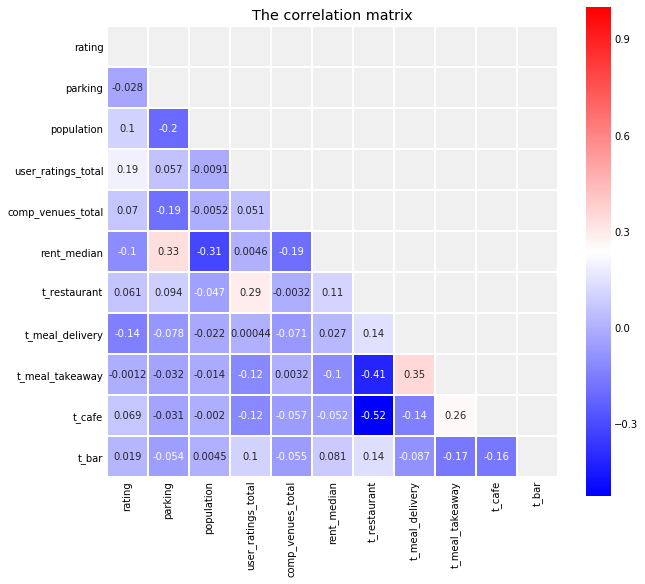

In [393]:
# Correlation Matrix
# Compute the correlation matrix
d = df.query('city == "Chicago"')[['rating', 'parking', 'population', 'user_ratings_total', 'comp_venues_total',
                                   'rent_median', 't_restaurant', 't_meal_delivery', 't_meal_takeaway', 't_cafe', 't_bar']]
correlation = d.corr(method='kendall')
# the masking code is taken from here: https://seaborn.pydata.org/examples/many_pairwise_correlations.html
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(9,9))
sns.heatmap(correlation, mask=mask, annot=True, square=True, cmap='bwr', linewidths=1)
plt.title('The correlation matrix')
plt.show()

### <font color=red> TODO: описать r_c <-> parking, population </font>
    будет время - описать отдельно по городам

### Preparing data for machine learning algorithms  
Scikit works best with normalized data, so I will normalize the data which is not one-hot encoded, and also take the exp or log (when needed) in order to get rid of the skewness and to allow for a more normal distribution.

In [424]:
# Choose only the variables I want to use in the model
columns = ['rating', 'parking', 'population', 'user_ratings_total', 'comp_venues_total', 'rent_median', 't_restaurant', 't_meal_delivery', 't_meal_takeaway', 't_cafe', 't_bar']
data_model = df.loc[:,columns]

In [31]:
data_model['rating'] = pd.cut(df.rating, 5, labels=[1,2,3,4,5])

In [425]:
data_model.head()

,rating,parking,population,user_ratings_total,comp_venues_total,rent_median,t_restaurant,t_meal_delivery,t_meal_takeaway,t_cafe,t_bar
0,4.0,50.0,26769.0,432,0.18,2367.4,1.0,0.0,0.0,0.0,0.0
1,2.7,50.0,26769.0,17,0.25,2367.4,1.0,0.0,0.0,0.0,0.0
2,4.3,50.0,26769.0,624,0.14,2367.4,1.0,0.0,0.0,0.0,0.0
3,4.5,50.0,26769.0,162,0.57,2367.4,1.0,0.0,0.0,0.0,0.0
4,4.2,50.0,26769.0,625,0.26,2367.4,1.0,1.0,1.0,0.0,0.0


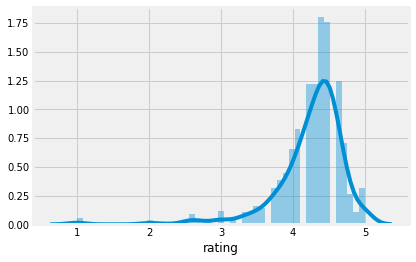

In [426]:
sns.distplot(data_model.rating)

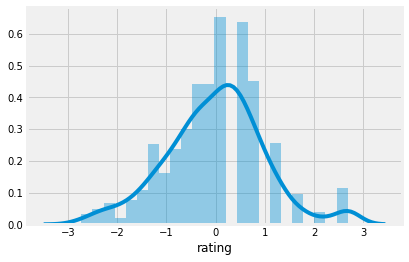

In [427]:
# Take exp and normalize:
data_model['rating'] = StandardScaler().fit_transform(np.exp(data_model.rating.values).reshape(-1,1))
sns.distplot(data_model['rating'])

In [428]:
data_model['parking'] = StandardScaler().fit_transform(np.exp(data_model.parking.values).reshape(-1,1))

In [429]:
data_model['population'] = StandardScaler().fit_transform(data_model.population.values.reshape(-1,1))

In [430]:
data_model['user_ratings_total'] = StandardScaler().fit_transform(data_model.user_ratings_total.values.reshape(-1,1))

The `comp_venues_total` var is left-skewed, so it needs to be 'logarithmized'. The problem is, some of the resulting values contain inf values. I'll replace them with the average values as follows:

In [431]:
x = np.log(data_model.comp_venues_total.values)

In [432]:
for i in range(len(x)):
    if ~np.isfinite(x[i]):
        x[i] = np.nan

In [433]:
for i in range(len(x)):
    if str(x[i]) == 'nan':
        x[i] = np.nanmean(x)

In [434]:
data_model['comp_venues_total'] = StandardScaler().fit_transform(x.reshape(-1,1))

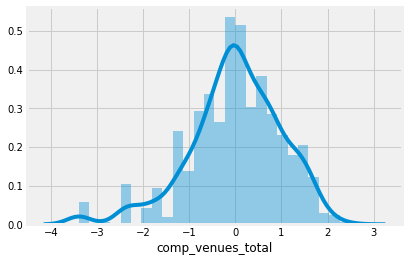

In [435]:
sns.distplot(data_model['comp_venues_total'])

In [436]:
data_model['rent_median'] = StandardScaler().fit_transform(np.log(data_model.rent_median.values).reshape(-1,1))

In [437]:
# backing up...
data_model.to_csv('data_model.csv', index=False)

In [438]:
# Split data into training and testing set with 80% of the data going into training
training, testing = train_test_split(data_model, test_size=0.2, random_state=0)
print("Total sample size = %i; training sample size = %i, testing sample size = %i"\
     %(data_model.shape[0],training.shape[0],testing.shape[0]))

Total sample size = 932; training sample size = 745, testing sample size = 187


In [439]:
#X are the variables/features that help predict y, which tells us whether an employee left or stayed. This is done for both 
#training and testing

df_train_s = training.loc[:,data_model.columns]
X_train_s = df_train_s.drop(['rating'], axis=1)
y_train_s = df_train_s.loc[:, ['rating']]

df_test_s = testing.loc[:,data_model.columns]
X_test_s = df_test_s.drop(['rating'], axis=1)
y_test_s = df_test_s.loc[:, ['rating']]

### Random forest

In [478]:
rf_reg = RandomForestRegressor()

rf_reg.fit(X_train_s, y_train_s.values)

y_pred_s_rf = rf_reg.predict(X_test_s)

# Compute 5-fold cross-validation scores: cv_scores
cv_scores_rf = cross_val_score(rf_reg, X_train_s, y_train_s, cv=5)

In [479]:
print("R^2: {}".format(rf_reg.score(X_test_s, y_test_s)))
rmse = np.sqrt(mean_squared_error(y_test_s, y_pred_s_rf))
print("Root Mean Squared Error: {}".format(rmse))

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores_rf)))
# Print the 5-fold cross-validation scores
print(cv_scores_rf)

R^2: 0.18048608158928903
Root Mean Squared Error: 0.8584043907885222
Average 5-Fold CV Score: 0.051574996957060096
[-0.01319334  0.1427325   0.26735068 -0.20575164  0.06673678]


In [480]:
importance = pd.DataFrame(list(zip(X_train_s.columns, np.transpose(rf_reg.feature_importances_))) \
            ).sort_values(1, ascending=False)
importance

,0,1
2,user_ratings_total,0.271072
4,rent_median,0.195674
3,comp_venues_total,0.180683
1,population,0.171222
0,parking,0.084910
6,t_meal_delivery,0.032540
7,t_meal_takeaway,0.022363
5,t_restaurant,0.019259
8,t_cafe,0.015479
9,t_bar,0.006798


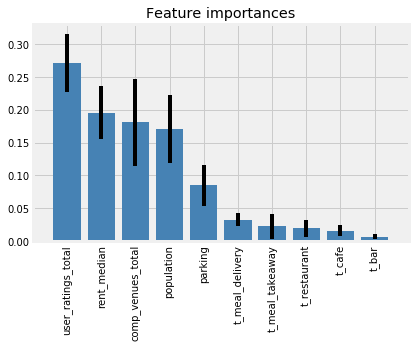

In [481]:
importances = rf_reg.feature_importances_

std = np.std([tree.feature_importances_ for tree in rf_reg.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train_s.shape[1]), importances[indices],  
       color="steelblue", yerr=std[indices], align="center")
plt.xticks(range(X_train_s.shape[1]),X_train_s.columns[indices], rotation=90)
#plt.xlim([-1, X_train_s.shape[1]])
plt.xlim([-1, 10])
plt.show()

In [423]:
df.head()

,name,lat,lng,rating,user_ratings_total,venues_total,venues_comp,parking,city,city_district,population,rent_median,t_restaurant,t_meal_delivery,t_meal_takeaway,t_cafe,t_bar,comp_venues_total
0,Pongal,40.742453,-73.982883,4.0,432,50.0,9.0,50.0,NYC,Manhattan,26769.0,2367.4,1.0,0.0,0.0,0.0,0.0,0.18
1,Juice Press,40.728551,-74.007428,2.7,17,24.0,6.0,50.0,NYC,Manhattan,26769.0,2367.4,1.0,0.0,0.0,0.0,0.0,0.25
2,Vatan,40.742361,-73.980337,4.3,624,50.0,7.0,50.0,NYC,Manhattan,26769.0,2367.4,1.0,0.0,0.0,0.0,0.0,0.14
3,Kajitsu,40.749853,-73.977721,4.5,162,21.0,12.0,50.0,NYC,Manhattan,26769.0,2367.4,1.0,0.0,0.0,0.0,0.0,0.57
4,Kailash Parbat,40.742063,-73.982706,4.2,625,50.0,13.0,50.0,NYC,Manhattan,26769.0,2367.4,1.0,1.0,1.0,0.0,0.0,0.26


## Decision tree

For the decision tree model we'll use catagorized feature values:

In [33]:
columns = ['rating', 'parking', 'population', 'user_ratings_total', 'comp_venues_total', 'rent_median', 't_restaurant', 't_meal_delivery', 't_meal_takeaway', 't_cafe', 't_bar']
DT_data_model = df.loc[:,columns]

In [34]:
DT_data_model['rating'] = pd.cut(df.rating, 5, labels=[1,2,3,4,5])
DT_data_model['popularity'] = pd.cut(df.user_ratings_total, 5, labels=[1,2,3,4,5])
DT_data_model['competition'] = pd.cut(df.comp_venues_total, 5, labels=[1,2,3,4,5])
DT_data_model['parking'] = pd.cut(df.parking, 5, labels=[1,2,3,4,5])
DT_data_model['population'] = pd.cut(df.population, 5, labels=[1,2,3,4,5])
DT_data_model['rental_cost'] = pd.cut(df.rent_median, 5, labels=[1,2,3,4,5])

In [35]:
DT_data_model.drop(['user_ratings_total', 'comp_venues_total', 'rent_median'], axis=1, inplace=True)

In [36]:
DT_data_model.head()

,rating,parking,population,t_restaurant,t_meal_delivery,t_meal_takeaway,t_cafe,t_bar,popularity,competition,rental_cost
0,4,5,2,1.0,0.0,0.0,0.0,0.0,1,1,3
1,3,5,2,1.0,0.0,0.0,0.0,0.0,1,2,3
2,5,5,2,1.0,0.0,0.0,0.0,0.0,1,1,3
3,5,5,2,1.0,0.0,0.0,0.0,0.0,1,3,3
4,4,5,2,1.0,1.0,1.0,0.0,0.0,1,2,3


In [38]:
# Split data into training and testing set with 80% of the data going into training
train, test = train_test_split(DT_data_model, test_size=0.2, random_state=3)
print("Total sample size = %i; training sample size = %i, testing sample size = %i"\
     %(DT_data_model.shape[0],train.shape[0],test.shape[0]))

Total sample size = 932; training sample size = 745, testing sample size = 187


In [39]:
df_train_set = train.loc[:,DT_data_model.columns]
X_train_set = df_train_set.drop(['rating'], axis=1)
y_train_set = df_train_set.loc[:, ['rating']]

df_test_set = test.loc[:,DT_data_model.columns]
X_test_set = df_test_set.drop(['rating'], axis=1)
y_test_set = df_test_set.loc[:, ['rating']]

In [162]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing

# lab_encoding = preprocessing.LabelEncoder() # to avoid "continuous label type" error
# DT_y_training_scores_encoded = lab_encoding.fit_transform(y_train_set)


param_grid = {'max_depth': np.arange(2, 5), 'max_features':np.arange(2, 11), 'criterion':['gini','entropy']}

grid = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=10, iid=False)
grid.fit(X_train_set, y_train_set)
print('Best params: {}'.format(grid.best_params_))
print('Best score: {}'.format(grid.best_score_))
final_tree = grid.best_estimator_

Best params: {'criterion': 'gini', 'max_depth': 3, 'max_features': 9}
Best score: 0.6084081785177676


In [163]:
final_tree

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=9, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [164]:
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline

<Figure size 936x1080 with 0 Axes>

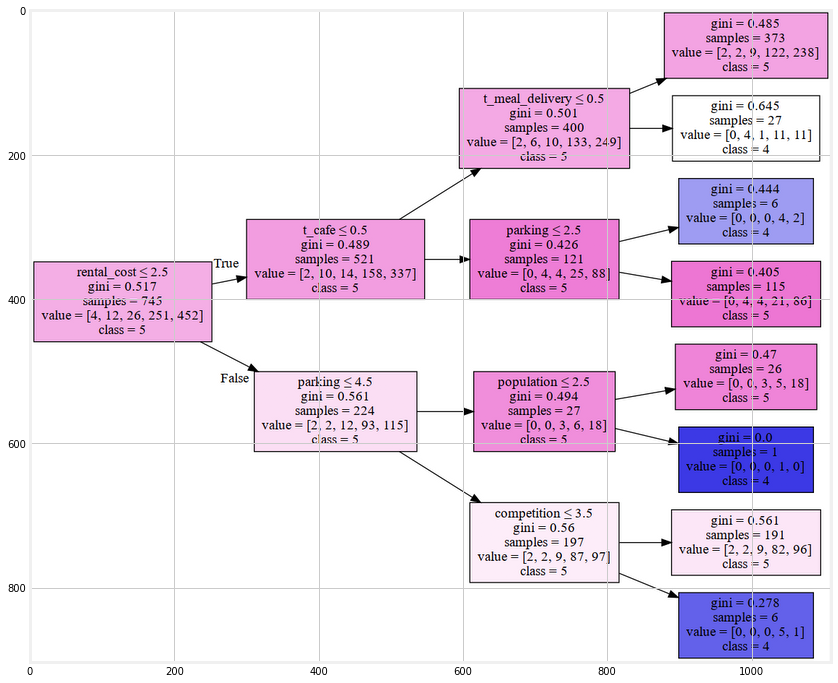

In [165]:
dot_data = StringIO()
filename = "tree.png"
plt.figure(figsize=(13,15))
featureNames = DT_data_model.columns[1:11]
targetNames = list(set(DT_data_model.rating))

out=tree.export_graphviz(final_tree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train_set).astype(str), filled=True,  special_characters=True,rotate=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)

img = mpimg.imread(filename)
plt.figure(figsize=(15,12))
plt.imshow(img,interpolation='lanczos')

In [166]:
from sklearn.metrics import accuracy_score
print("DecisionTrees's Accuracy: ", accuracy_score(y_test_set, final_tree.predict(X_test_set)))

DecisionTrees's Accuracy:  0.5989304812834224


## Hierarchy clustering

In [243]:
featureset = data_model.copy()

In [244]:
from sklearn.preprocessing import MinMaxScaler
x = featureset.values #returns a numpy array
min_max_scaler = MinMaxScaler()
feature_mtx = min_max_scaler.fit_transform(x)
feature_mtx [0:5]

array([[0.75      , 1.        , 0.38159114, 0.09652856, 0.18      ,
        0.51487342, 1.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.5       , 1.        , 0.38159114, 0.00358343, 0.25      ,
        0.51487342, 1.        , 0.        , 0.        , 0.        ,
        0.        ],
       [1.        , 1.        , 0.38159114, 0.13952968, 0.14      ,
        0.51487342, 1.        , 0.        , 0.        , 0.        ,
        0.        ],
       [1.        , 1.        , 0.38159114, 0.03605823, 0.57      ,
        0.51487342, 1.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.75      , 1.        , 0.38159114, 0.13975364, 0.26      ,
        0.51487342, 1.        , 1.        , 1.        , 0.        ,
        0.        ]])

A huge jump in distance is typically what we're interested in if we want to argue for a certain number of clusters:

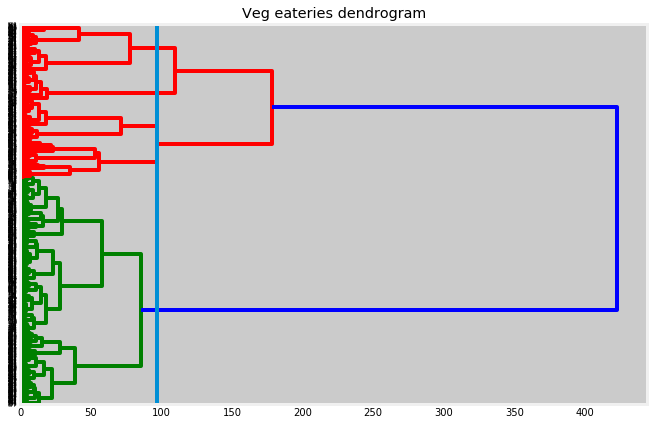

In [335]:
import scipy.cluster.hierarchy as shc
from scipy.spatial import distance_matrix

dist_matrix = distance_matrix(feature_mtx,feature_mtx) 
plt.figure(figsize=(10, 7))
plt.axvline(97)
plt.title("Veg eateries dendrogram")  
dend = shc.dendrogram(shc.linkage(dist_matrix, method='ward' ),  leaf_rotation=0, orientation = 'right')

In [489]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')  
cluster.fit_predict(dist_matrix)
df_hier = data_model.copy()
df_hier['cluster'] = cluster.labels_
df_hier['city'] = df.city
df_hier['city_district'] = df.city_district
df_hier['lat'] = df.lat
df_hier['lng'] = df.lng

In [490]:
df_hier.head()

,rating,parking,population,user_ratings_total,comp_venues_total,rent_median,t_restaurant,t_meal_delivery,t_meal_takeaway,t_cafe,t_bar,cluster,city,city_district,lat,lng
0,-0.800456,1.204231,0.181975,0.377188,-0.090316,0.878938,1.0,0.0,0.0,0.0,0.0,0,NYC,Manhattan,40.742453,-73.982883
1,-2.274546,1.204231,0.181975,-0.657756,0.403693,0.878938,1.0,0.0,0.0,0.0,0.0,0,NYC,Manhattan,40.728551,-74.007428
2,-0.091527,1.204231,0.181975,0.856005,-0.468246,0.878938,1.0,0.0,0.0,0.0,0.0,0,NYC,Manhattan,40.742361,-73.980337
3,0.514066,1.204231,0.181975,-0.296149,1.643099,0.878938,1.0,0.0,0.0,0.0,0.0,0,NYC,Manhattan,40.749853,-73.977721
4,-0.351821,1.204231,0.181975,0.858499,0.462673,0.878938,1.0,1.0,1.0,0.0,0.0,4,NYC,Manhattan,40.742063,-73.982706


For more convenient analysis some data need to be categorized (see the description of categories from the table at the beginning of the notebook)

In [338]:
df_hier['rating'] = pd.cut(df.rating, 5, labels=[1,2,3,4,5])
df_hier['popularity'] = pd.cut(df.user_ratings_total, 5, labels=[1,2,3,4,5])
df_hier['competition'] = pd.cut(df.comp_venues_total, 5, labels=[1,2,3,4,5])
df_hier['parking'] = pd.cut(df.parking, 5, labels=[1,2,3,4,5])
df_hier['population'] = pd.cut(df.population, 5, labels=[1,2,3,4,5])
df_hier['rental_cost'] = pd.cut(df.rent_median, 5, labels=[1,2,3,4,5])

In [339]:
df_hier.drop(['user_ratings_total', 'comp_venues_total', 'rent_median'], axis=1, inplace=True)

In [341]:
df_hier.head()

,rating,parking,population,t_restaurant,t_meal_delivery,t_meal_takeaway,t_cafe,t_bar,cluster,city,city_district,lat,lng,popularity,competition,rental_cost
0,4,5,2,1.0,0.0,0.0,0.0,0.0,0,NYC,Manhattan,40.742453,-73.982883,1,1,3
1,3,5,2,1.0,0.0,0.0,0.0,0.0,0,NYC,Manhattan,40.728551,-74.007428,1,2,3
2,5,5,2,1.0,0.0,0.0,0.0,0.0,0,NYC,Manhattan,40.742361,-73.980337,1,1,3
3,5,5,2,1.0,0.0,0.0,0.0,0.0,0,NYC,Manhattan,40.749853,-73.977721,1,3,3
4,4,5,2,1.0,1.0,1.0,0.0,0.0,4,NYC,Manhattan,40.742063,-73.982706,1,2,3


In [ ]:
### сюда объяснение, почему не будем использовать карту -- нет смысла, анализировали в отрыве от локаций.

In [312]:
from geopy.geocoders import Nominatim
address = 'Chicago, IL'

geolocator = Nominatim(user_agent="coursera-capstone") 
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geo coordinates of Chicago are {}, {}.'.format(latitude, longitude))

The geo coordinates of Chicago are 41.8755616, -87.6244212.


In [331]:
_ = df_hier.query('city == "Chicago"' )
# I will be using the same coordinates for the previous view
tmap = folium.Map(location=[latitude, longitude], zoom_start=11)

# clr = dict({0:'steelblue', 1:'yellowgreen', 2:'tomato', 3:'mediumpurple', 4:'gold', 5:'gray', 6:'pink', 7:'red', 8:'blue'})
clr = dict({0:'gold', 1:'tomato', 2:'steelblue', 3:'mediumpurple', 4:'lightblue', 5:'yellow', 6:'orange', 7:'pink', 8:'gray'})
# add markers to map
for lat, lng, label, clust in zip(_['lat'], _['lng'], _.index, _.cluster):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color=clr[clust],
        fill=True,
        fill_color=clr[clust],
        fill_opacity=0.5,
        parse_html=False).add_to(tmap)  

In [332]:
tmap

In [491]:
df_hier.cluster.value_counts()

0    557
2    114
1    98 
4    93 
3    70 
Name: cluster, dtype: int64

In [492]:
df_hier.columns

Index(['rating', 'parking', 'population', 'user_ratings_total',
       'comp_venues_total', 'rent_median', 't_restaurant', 't_meal_delivery',
       't_meal_takeaway', 't_cafe', 't_bar', 'cluster', 'city',
       'city_district', 'lat', 'lng'],
      dtype='object')

In [495]:
df['cluster'] = df_hier.cluster

In [557]:
df_cat['rating'] = df.rating

In [553]:
# df_cat['rating'] = pd.cut(df.rating, 5, labels=[1,2,3,4,5]).astype(int)

In [564]:
_ = df_cat.groupby(['cluster'])['rating', 'user_ratings_total', 'rent_median', 'comp_venues_total', 'population'].median().fillna(value=0)

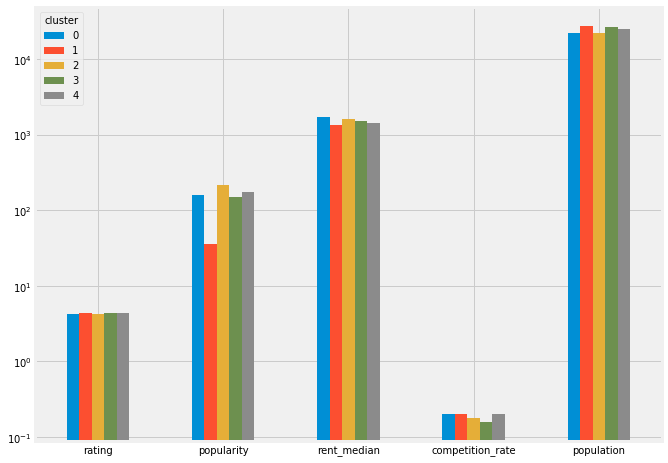

In [565]:
_.columns = ['rating', 'popularity', 'rent_median', 'competition_rate', 'population']
_.T.plot.bar(figsize=(10,8))
plt.yscale('log')
plt.xticks(rotation=0)
plt.show()

In [566]:
_

,rating,popularity,rent_median,competition_rate,population
cluster,,,,,
0,4.30,161.0,1705.000000,0.20,22390.0
1,4.40,35.5,1331.000000,0.20,27319.5
2,4.30,213.5,1635.666667,0.18,22390.0
3,4.45,150.0,1505.975000,0.16,26680.5
4,4.40,176.0,1455.000000,0.20,25096.0


In [ ]:
# some bonus graphs not included into the analysis

Text(0.5, 0, 'NY city districts')

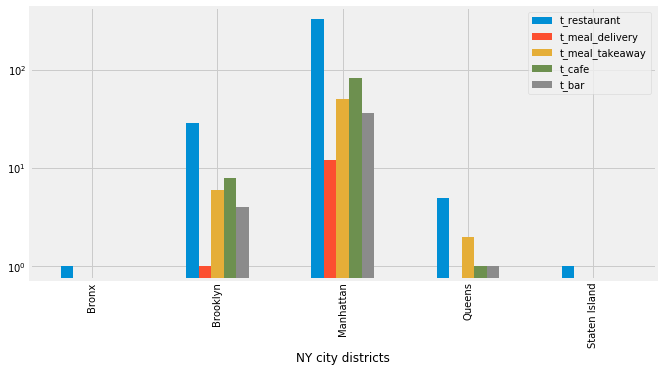

In [379]:
df.iloc[:,[8,9,12,13,14,15,16]].query('city == "NYC"').groupby('city_district').sum().plot.bar(figsize=(10,5))
plt.yscale('log')
plt.xlabel('NY city districts')

Text(0.5, 0, 'LA city districts')

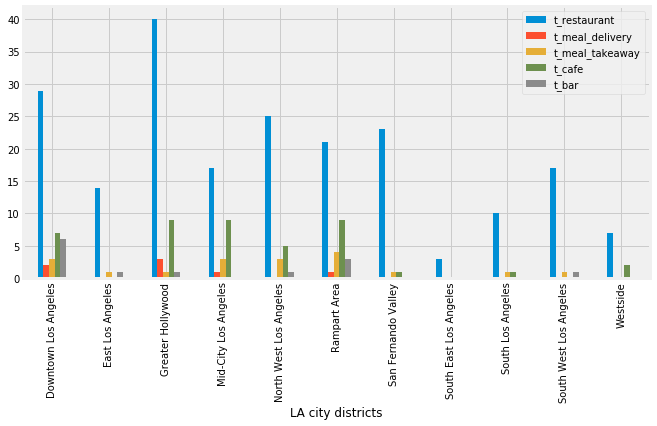

In [381]:
df.iloc[:,[8,9,12,13,14,15,16]].query('city == "LA"').groupby('city_district').sum().plot.bar(figsize=(10,5))
# plt.yscale('log')
plt.xlabel('LA city districts')

Text(0.5, 0, 'Chicago city districts')

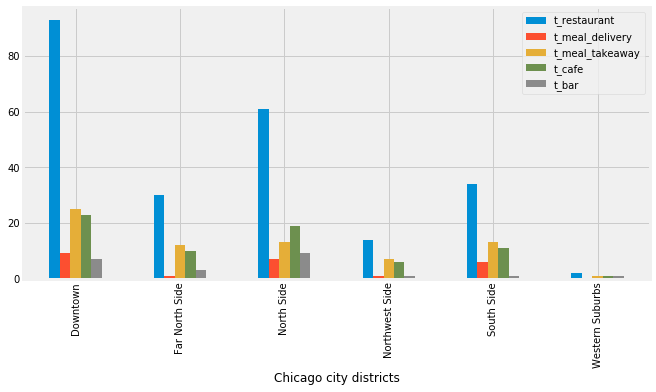

In [380]:
df.iloc[:,[8,9,12,13,14,15,16]].query('city == "Chicago"').groupby('city_district').sum().plot.bar(figsize=(10,5))
# plt.yscale('log')
plt.xlabel('Chicago city districts')

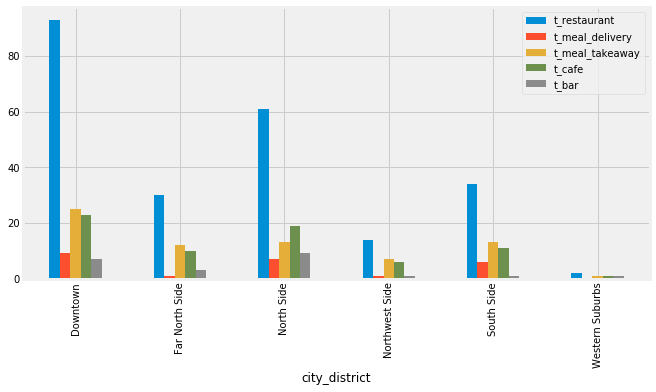

In [363]:
df.iloc[:,[8,9,12,13,14,15,16]].query('city == "Chicago"').groupby('city_district').sum().plot.bar(figsize=(10,5))
# plt.yscale('log')